# Bounding Box Model
This notebook explains how to generate a bounding box model. The idea for this model stems from Martin Piotte's [model](https://www.kaggle.com/martinpiotte/bounding-box-model/output) though my implementation uses fast.ai and Pytorch instead of Keras.<br/>
While many of the whale pictures in the dataset are already cropped tight around the whale fluke, in some images the whale fluke occupies only a small area of the picture. Zooming in the relevant part of the picture provides greater accuracy to a classification model. To automate the process, this notebook explains how to construct a convolutional neural network (CNN) capable of estimating the whale bounding box.<br/>
Using this model, whale pictures can be cropped automatically to a more uniform appearance. This facilitates training of classification models, and improves the test accuracy.<br/>
Training of the bounding box model is performed over a dataset of 1200 bounding boxes for pictures selected from the Humpback Whale Identification Challenge training set. 1000 pictures are used for training, while 200 are reserved for validation.

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
from fastai import *
from fastai.vision import *

# Read the cropping dataset
Once decoded, the variable *data* is a list of tuples. Each tuple contains the picture filename and a list of coordinates.

In [6]:
with open('cropping.txt', 'rt') as f: data = f.read().split('\n')[:-1]
data = [line.split(',') for line in data]
data = [(p,[(int(coord[i]),int(coord[i+1])) for i in range(0,len(coord),2)]) for p,*coord in data]
data[0] # Show an example: (picture-name, [coordinates])

('88532e70.jpg',
 [(195, 293),
  (269, 115),
  (868, 158),
  (888, 170),
  (641, 496),
  (512, 546),
  (321, 524)])

The coordinates represent points on the fluke edge. The extremum values can be used to construct a bounding box.

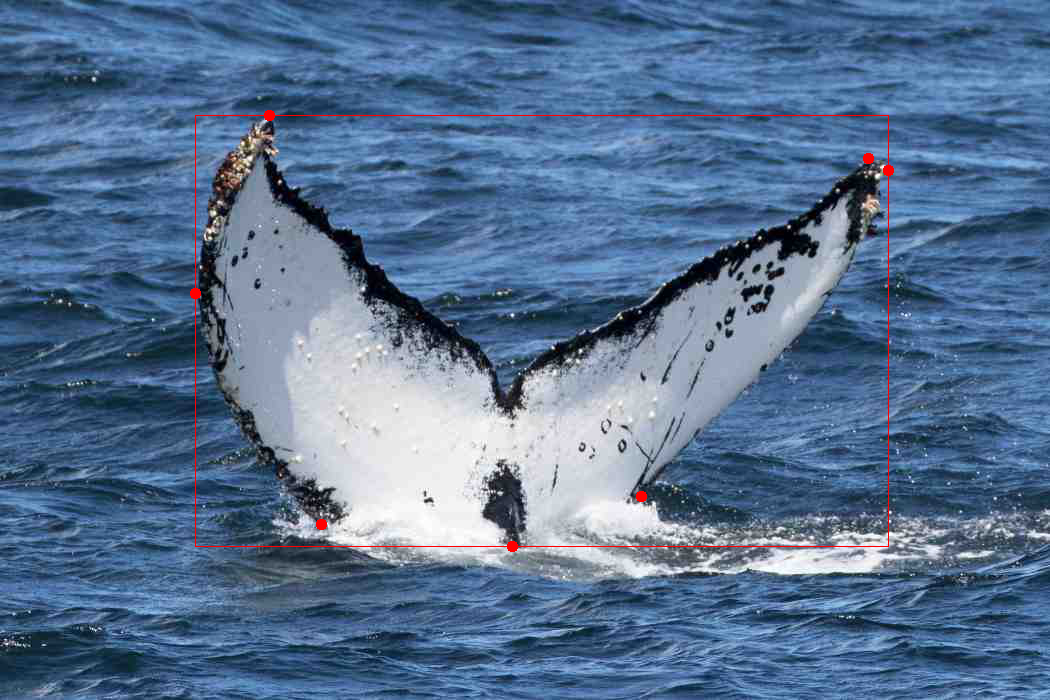

In [9]:
from PIL import Image as pil_image
from PIL.ImageDraw import Draw
from os.path import isfile

def expand_path(p):
    if isfile('train/' + p): return 'train/' + p
    if isfile('test/' + p): return 'test/' + p
    return p

def read_raw_image(p):
    return pil_image.open(expand_path(p))

def draw_dot(draw, x, y):
    draw.ellipse(((x-5,y-5),(x+5,y+5)), fill='red', outline='red')

def draw_dots(draw, coordinates):
    for x,y in coordinates: draw_dot(draw, x, y)

def bounding_rectangle(list):
    x0, y0 = list[0]
    x1, y1 = x0, y0
    for x,y in list[1:]:
        x0 = min(x0, x)
        y0 = min(y0, y)
        x1 = max(x1, x)
        y1 = max(y1, y)
    return x0,y0,x1,y1

filename,coordinates = data[0]
box = bounding_rectangle(coordinates)
img = read_raw_image(filename)
draw = Draw(img)
draw_dots(draw, coordinates)
draw.rectangle(box, outline='red')
img

# Image preprocessing code
Images are preprocessed by:
1. Converting to black & white;
2. Compressing horizontally by a factor of 2.15 (the mean aspect ratio);
3. Apply a random image transformation (only for training)
4. Resizing to 128x128;
5. Normalizing to zero mean and unit variance.

These operation are performed by the following code that is later invoked when preparing the corpus.

In [26]:
# Define useful constants
img_shape  = (128,128,1)
anisotropy = 2.15

In [36]:
#a = read_raw_image('88532e70.jpg').convert('L')#open_image('train/88532e70.jpg',convert_mode="L") 
#b = image2np(pil2tensor(a, np.float32).div_(255))
#b = array(a)
#pil_image.fromarray(b)
a = open_image('train/88532e70.jpg',convert_mode='L')
a.data.normalize

AttributeError: 'Tensor' object has no attribute 'normalize'

In [28]:
import random
import numpy as np
from scipy.ndimage import affine_transform

# Read an image as black&white numpy array
def img_to_array(img):
    return image2np(pil2tensor(a, np.float32).div_(255))#array(img)

def array_to_img(arr):
    return pil_image.fromarray(arr)

def read_array(p):
    img = read_raw_image(p).convert('L')
    return img_to_array(img)

def build_transform(rotation, shear, height_zoom, width_zoom, height_shift, width_shift):
    rotation        = np.deg2rad(rotation)
    shear           = np.deg2rad(shear)
    rotation_matrix = np.array([[np.cos(rotation), np.sin(rotation), 0], [-np.sin(rotation), np.cos(rotation), 0], [0, 0, 1]])
    shift_matrix    = np.array([[1, 0, height_shift], [0, 1, width_shift], [0, 0, 1]])
    shear_matrix    = np.array([[1, np.sin(shear), 0], [0, np.cos(shear), 0], [0, 0, 1]])
    zoom_matrix     = np.array([[1.0/height_zoom, 0, 0], [0, 1.0/width_zoom, 0], [0, 0, 1]])
    shift_matrix    = np.array([[1, 0, -height_shift], [0, 1, -width_shift], [0, 0, 1]])
    return np.dot(np.dot(rotation_matrix, shear_matrix), np.dot(zoom_matrix, shift_matrix))

# Compute the coordinate transformation required to center the pictures, padding as required.
def center_transform(affine, input_shape):
    hi, wi = float(input_shape[0]), float(input_shape[1])
    ho, wo = float(img_shape[0]), float(img_shape[1])
    top, left, bottom, right = 0, 0, hi, wi
    if wi/hi/anisotropy < wo/ho: # input image too narrow, extend width
        w     = hi*wo/ho*anisotropy
        left  = (wi-w)/2
        right = left + w
    else: # input image too wide, extend height
        h      = wi*ho/wo/anisotropy
        top    = (hi-h)/2
        bottom = top + h
    center_matrix   = np.array([[1, 0, -ho/2], [0, 1, -wo/2], [0, 0, 1]])
    scale_matrix    = np.array([[(bottom - top)/ho, 0, 0], [0, (right - left)/wo, 0], [0, 0, 1]])
    decenter_matrix = np.array([[1, 0, hi/2], [0, 1, wi/2], [0, 0, 1]])
    return np.dot(np.dot(decenter_matrix, scale_matrix), np.dot(affine, center_matrix))

# Apply an affine transformation to an image represented as a numpy array.
def transform_img(x, affine):
    matrix   = affine[:2,:2]
    offset   = affine[:2,2]
    x        = np.moveaxis(x, -1, 0)
    channels = [affine_transform(channel, matrix, offset, output_shape=img_shape[:-1], order=1,
                                 mode='constant', cval=np.average(channel)) for channel in x]
    return np.moveaxis(np.stack(channels, axis=0), 0, -1)

# Read an image for validation, i.e. without data augmentation.
def read_for_validation(p):
    x  = read_array(p)
    t  = np.array([[1, 0, 0], [0, 1, 0], [0, 0, 1]])
    t  = center_transform(t, x.shape)
    x  = transform_img(x, t)
    x -= np.mean(x, keepdims=True)
    x /= np.std(x, keepdims=True) + K.epsilon()
    return x,t 

# Read an image for training, i.e. including a random affine transformation
def read_for_training(p):
    x  = read_array(p)
    t  = build_transform(
            random.uniform(-5, 5),
            random.uniform(-5, 5),
            random.uniform(0.9, 1.0),
            random.uniform(0.9, 1.0),
            random.uniform(-0.05*img_shape[0], 0.05*img_shape[0]),
            random.uniform(-0.05*img_shape[1], 0.05*img_shape[1]))
    t  = center_transform(t, x.shape)
    x  = transform_img(x, t)
    x -= np.mean(x, keepdims=True)
    x /= np.std(x, keepdims=True) + K.epsilon()
    return x,t   

# Transform corrdinates according to the provided affine transformation
def coord_transform(list, trans):
    result = []
    for x,y in list:
        y,x,_ = trans.dot([y,x,1]).astype(np.int)
        result.append((x,y))
    return result

# Prepare the corpus
Split the corpus between training and validation data. Duplicate the training data 16 times to make reasonable size training epochs.

In [29]:
from sklearn.model_selection import train_test_split

train, val = train_test_split(data, test_size=200, random_state=1)
train += train
train += train
train += train
train += train
len(train),len(val)

(16000, 200)

In [30]:
import matplotlib.pyplot as plt
from tqdm import tqdm, tqdm_notebook
from numpy.linalg import inv as mat_inv

def show_whale(imgs, per_row=5):
    n         = len(imgs)
    rows      = (n + per_row - 1)//per_row
    cols      = min(per_row, n)
    fig, axes = plt.subplots(rows,cols, figsize=(24//per_row*cols,24//per_row*rows))
    for ax in axes.flatten(): ax.axis('off')
    for i,(img,ax) in enumerate(zip(imgs, axes.flatten())): ax.imshow(img.convert('RGB'))

val_a = np.zeros((len(val),)+img_shape,dtype='float32') # Preprocess validation images 
val_b = np.zeros((len(val),4),dtype='float32') # Preprocess bounding boxes
for i,(p,coords) in enumerate(tqdm_notebook(val)):
    img,trans      = read_for_validation(p)
    coords         = coord_transform(coords, mat_inv(trans))
    x0,y0,x1,y1    = bounding_rectangle(coords)
    val_a[i,:,:,:] = img
    val_b[i,0]     = x0
    val_b[i,1]     = y0
    val_b[i,2]     = x1
    val_b[i,3]     = y1

idx  = 1
img  = array_to_img(val_a[idx])
img  = img.convert('RGB')
draw = Draw(img)
draw.rectangle(val_b[idx], outline='red')
show_whale([read_raw_image(val[idx][0]), img], per_row=2)

ValueError: Expected homogeneous transformation matrix with shape (2, 2) for image shape (700,), but bottom row was not equal to [0, 1]